In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
# Reading Data
train_url = '/kaggle/input/titanic/train.csv'
test_url =  '/kaggle/input/titanic/test.csv'

train = pd.read_csv(train_url) 
test = pd.read_csv(test_url) 

In [4]:
# Age, Cabin, Embarked
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# All function needed for new features 
def Correct_Age(age):
    return math.ceil(age)

def Get_Title(sentance):
    for w in sentance.split():
        if "." in w:
            return w.replace(".", "").lower()       

def Get_Surname(sentance):
    return sentance.split()[0].replace(",", "")

def Correct_Title(df):
    # mlle, ms, countess, mme, lady  ---> miss
    miss_list = ["mlle", "ms", "countess", "mme", "lady"]
    for i in miss_list:
        df.loc[df.Title == i, "Title"] = "miss"
    
    # Compine passenger who work in value job or has ranked title together in special 
    job_title = ['don', 'rev', 'dr', 'major', 'sir','col', 'capt', 'jonkheer']  
    for i in job_title:
        df.loc[df.Title == i, "Title"] = "special"
    
    # Get Master Ages
    max_age = df[df.Title == "master"]["Age"].max()
    
    #Specify Girl category in Title to miss's with age <= max master age
    girls = (df.Title == "miss") & (df.Age <= max_age)
    df.loc[girls, "Title"] = "girl"

    return df["Title"]

def Get_Child(df):
    
    df["child"] = 0
    
    # master and girl categories only 
    child_cat = (df.Title == "master") | (df.Title == "girl")
    
    # Assign 1 in child column to child_cat 
    df.loc[child_cat, "child"] = 1  
    return df["child"]

def Fill_null_age(df):
    df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('median'))
    return df['Age']

def Correct_Cabin(df):
    
    # Get "Cabin" values that have more than one cabin
    combined_cabin = [c for c in df["Cabin"].unique()[1:] if (len(c) > 4) and (c[0] != "F")]
    f_combined_cabins = [c for c in df["Cabin"].unique()[1:] if (len(c) > 4) and (c[0] == "F")]
    
    #  take just the first cabin for them all combined_cabin
    for cc in combined_cabin:
        df.loc[df.Cabin == cc, "Cabin"] = cc.split()[0].strip()
    
    for cc in f_combined_cabins:
        df.loc[df.Cabin == cc, "Cabin"] = cc.split()[1]
    


def Get_CabinClass(df):
    # Cabin_values {'A', 'B', 'C', 'D', 'E', 'F', 'G', 'unknown'}
    #--------------{ 7,   6,   5,   4,   3,   2,   1,     0}
    CabinClass = df["Cabin"].str[0]
    mapping = {'A': 7,
               'B': 6,
               'C': 5,
               'D': 4,
               'E': 3,
               'F': 2,
               'G': 1}
    return CabinClass.map(mapping)

def Get_CabinNumber(df):
    # Add new feature, the number of cabin
    df["CabinNum"] = df["Cabin"].str[1:].replace("", "0").astype(float)
    return df["CabinNum"]

def fill_nan_cabine(pclass, nan_length):

    # Cabin_values {'A', 'B', 'C', 'D', 'E', 'F', 'G', 'unknown'}
    #--------------{ 7,   6,   5,   4,   3,   2,   1,     0}
    
    # Cabin_values for each pclass
    # pclass 1 --> {A', 'B', 'C', 'D', 'E'}
    # pclass 2 ----------------->{'D', 'E', 'F'}
    # pclass 3 ---------------------->{'E', 'F', 'G'}
    
    # Generate random cabins and return it
    if pclass == 1:
        return pd.Series(np.random.randint(3, 8, nan_length)).values
        
    elif pclass == 2:
        return pd.Series(np.random.randint(2, 5, nan_length)).values
        
    else:
        return pd.Series(np.zeros(nan_length)).values
    
def fill_nan_cabine_number(nan_length):
    return np.random.randint(1, 150, nan_length)

def Get_HaveCabin(df):
    df["HaveCabin"] = df["CabinClass"].notnull()
    return df["HaveCabin"]


def cal_position_x(num):
    # right > left cause the crush happen first in right side of the  ship
    # unknown -->0
    # left --> 1
    # right --> 2
    if math.isnan(num) == False:
        if num % 2 == 0:
            # left --> even
            return 1
        else:
            return 2
    else:
        return 0
        
def cal_position_y(num):
    # Since The front half of the ship reaches the bottom first
    # unknown -->0
    # back --> 1
    # middle --> 2
    # front --> 3
    
    if math.isnan(num) == False:
        if num <= 45:
            # the front part 
            return 3
        elif ((num >= 46) and (num <= 90)):
            # the middle part
            return 2
        elif num > 90:
            return 1
    else:
        return 0

0    0.616162
1    0.383838
Name: Survived, dtype: float64


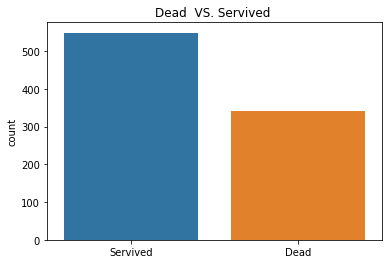

In [7]:
# Traveller who Servived VS. who died 
print(train["Survived"].value_counts(normalize=True))

sns.countplot(x="Survived", data=train).set_xticklabels(["Servived", "Dead"])
plt.title("Dead  VS. Servived ")
plt.xlabel("");

Note :
According to this dataset <br>Who died > Who survived

Sex     Survived
male    0           468
female  1           233
male    1           109
female  0            81
dtype: int64


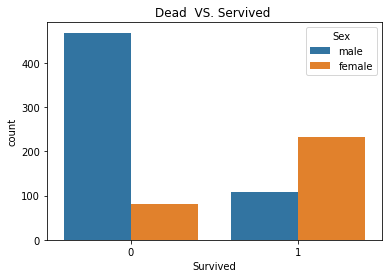

In [8]:
# Traveller's gender who Servived VS. who died 
print(train[["Sex", "Survived"]].value_counts())

plt.title("Dead  VS. Servived ");
sns.countplot(x="Survived", hue="Sex", data=train);

Note:
Survived Female > Survived male
Dead female < than Dead male

In [9]:
# Traveller's class who Servived VS. who died 
print(train.groupby("Pclass")["Survived"].value_counts(normalize=True))

Pclass  Survived
1       1           0.629630
        0           0.370370
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
Name: Survived, dtype: float64


Note: <br>
class 1 has the least Death <br>
class 1 has the most Survivors <br>

class 3 has the most Death <br>

Survivors:<br>
class 1 > class 2 > class 3<br>

Death:<br>
class 3 > class 2 > class 1<br>

Pclass  Sex     Survived
1       female  1           0.968085
                0           0.031915
        male    0           0.631148
                1           0.368852
2       female  1           0.921053
                0           0.078947
        male    0           0.842593
                1           0.157407
3       female  0           0.500000
                1           0.500000
        male    0           0.864553
                1           0.135447
Name: Survived, dtype: float64


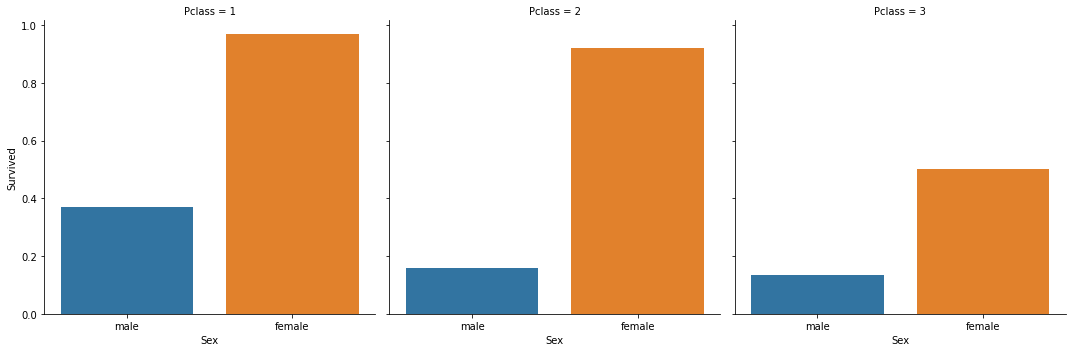

In [10]:
# Traveller's class who Servived VS. who died 
print(train.groupby(["Pclass", "Sex"])["Survived"].value_counts(normalize=True))
sns.catplot(x="Sex", y="Survived", col="Pclass", kind="bar", ci=None, data=train);

Note: <br>
Most of Survivors in all classes were Females 

===========================================

# Explore columns in Titanic data set

##  Explore Age column

In [11]:
# Explore Age column
train["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Note: <br> It dosen't make sense to have age less than 1 !!


In [12]:
# Get columns that have age less than 1
train[train["Age"] < 1].sort_values("Pclass")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C


Proplems to Explore:<br>
1- Are people with master title in their name, Children ???<br>
2- Are passengers with id 470, 645 sibiling ??<br>

In [13]:
# Explore Age of people who has "Master" title in there name 
people_master = train[train["Name"].str.contains("Master")].sort_values("Pclass")
display(people_master)
display(people_master.describe())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
445,446,1,1,"Dodge, Master. Washington",male,4.00,0,2,33638,81.8583,A34,S
802,803,1,1,"Carter, Master. William Thornton II",male,11.00,1,2,113760,120.0000,B96 B98,S
340,341,1,2,"Navratil, Master. Edmond Roger",male,2.00,1,1,230080,26.0000,F2,S
193,194,1,2,"Navratil, Master. Michel M",male,3.00,1,1,230080,26.0000,F2,S
183,184,1,2,"Becker, Master. Richard F",male,1.00,2,1,230136,39.0000,F4,S
549,550,1,2,"Davies, Master. John Morgan Jr",male,8.00,1,1,C.A. 33112,36.7500,NaN,S
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
827,828,1,2,"Mallet, Master. Andre",male,1.00,0,2,S.C./PARIS 2079,37.0042,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,40.000000,40.000000,40.000000,36.000000,40.000000,40.000000,40.000000
mean,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,34.703125
std,301.717518,0.500641,0.627878,3.619872,1.910833,0.540062,28.051752
min,8.000000,0.000000,1.000000,0.420000,0.000000,0.000000,8.516700
25%,165.750000,0.000000,2.000000,1.000000,1.000000,1.000000,18.750000
50%,345.000000,1.000000,3.000000,3.500000,1.000000,1.000000,29.062500
75%,764.000000,1.000000,3.000000,8.000000,4.000000,2.000000,39.171875
max,870.000000,1.000000,3.000000,12.000000,8.000000,2.000000,151.550000


People who has "Master" in there name are <br>
1- male <br>
2- Maxumim Age is: 12<br>
3- All of them have value in "Parch" columns whice mean they might have parent or children <br>
So, Conclusion: <br>
    &emsp;  1- They are childern <br>

if child'age = 10 months <br>
in this data set will be 10/12 = 0.83 <br>
So, I'm gonna rounds the age up to the next largest age to simplify numbers and prevent outliers <br>

In [14]:
# Correct age 
train_small_ages = (train.Age < 1)
train.loc[train_small_ages, "Age"] = train.loc[train_small_ages, "Age"].apply(Correct_Age)

test_small_ages = (test.Age < 1)
test.loc[test_small_ages, "Age"] = test.loc[test_small_ages, "Age"].apply(Correct_Age)


In [15]:
# Explore passengers who has "Baclini" in their name 
train[train["Name"].str.contains("Baclini")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
448,449,1,3,"Baclini, Miss. Marie Catherine",female,5.0,2,1,2666,19.2583,NaN,C
469,470,1,3,"Baclini, Miss. Helene Barbara",female,1.0,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,1.0,2,1,2666,19.2583,NaN,C
858,859,1,3,"Baclini, Mrs. Solomon (Latifa Qurban)",female,24.0,0,3,2666,19.2583,NaN,C


Conclusion: <br>
According to encyclopedia-titanica website those two girles one was 2.9 and the other was 3  <br>
and this is a mistake in this dataset<br>
&emsp; Mrs.Solomon is the mother of 3 daughters Marie, Helene , and Eugenie<br>
&emsp; So, We will fix Helene , and Eugenie 'age from 0.75 to 7 years old<br>

In [16]:
# Fixing Helene's age 
train.loc[469, "Age"] = 3

# Fixing Eugenie's age
train.loc[644, "Age"] = 3

In [17]:
train["Age"].describe()

count    714.000000
mean      29.707283
std       14.510688
min        1.000000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [18]:
# Get null values in Age col.
null_age = train["Age"].isnull()
print("Number of null values in age column: ", null_age.sum())

Number of null values in age column:  177


In [19]:
# Explore why these rows have null ages
train[null_age].groupby("Pclass")["PassengerId"].count()

Pclass
1     30
2     11
3    136
Name: PassengerId, dtype: int64

Note: most of null ages are in class 3 which make sense, they might neglect to collect information about people from class c 

In [20]:
# View observations from class 3 who have missing age 
x = train[null_age]
x[x.Pclass == 3].sort_values("SibSp", ascending=False).tail(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
444,445,1,3,"Johannesen-Bratthammer, Mr. Bernt",male,NaN,0,0,65306,8.1125,NaN,S
77,78,0,3,"Moutal, Mr. Rahamin Haim",male,NaN,0,0,374746,8.0500,NaN,S
428,429,0,3,"Flynn, Mr. James",male,NaN,0,0,364851,7.7500,NaN,Q
425,426,0,3,"Wiseman, Mr. Phillippe",male,NaN,0,0,A/4. 34244,7.2500,NaN,S
420,421,0,3,"Gheorgheff, Mr. Stanio",male,NaN,0,0,349254,7.8958,NaN,C
415,416,0,3,"Meek, Mrs. Thomas (Annie Louise Rowley)",female,NaN,0,0,343095,8.0500,NaN,S
411,412,0,3,"Hart, Mr. Henry",male,NaN,0,0,394140,6.8583,NaN,Q
410,411,0,3,"Sdycoff, Mr. Todor",male,NaN,0,0,349222,7.8958,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


Note: Name contain "Surname", "title". "first_name" "last_name" <br>
Solutions for this problem: <br>
&emsp; 1- fill null ages with passenger's mean ages who had same title <br>

In [21]:
# Get Surname & Title
train["Surname"] = train["Name"].apply(Get_Surname)
train["Title"] = train["Name"].apply(Get_Title)

test["Surname"] = test["Name"].apply(Get_Surname)
test["Title"] = test["Name"].apply(Get_Title)

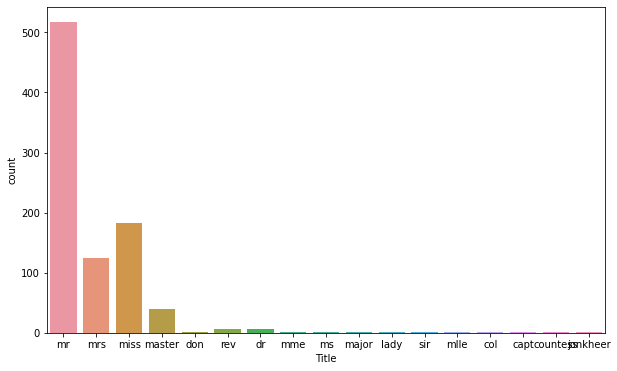

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x='Title', data=train, ax=ax);

In [23]:
title_count = train["Title"].value_counts()
title_count

mr          517
miss        182
mrs         125
master       40
dr            7
rev           6
mlle          2
major         2
col           2
countess      1
capt          1
ms            1
sir           1
lady          1
mme           1
don           1
jonkheer      1
Name: Title, dtype: int64

******************************************************************************************** <br>
miss: Unmarried woman <br>
mlle: Miss <br>
lady: Women of a high social class <br>
ms: married or unmarried women <br>
mrs: Married woman <br>
mme: Sometimes Married woman <br>
countess: the wife or widow of an earl or count <br>
******************************************************************************************** <br>
 <br>
master: English honorific for boys and young men <br>
mr: men under the rank of knighthood married or not  <br>
********************************************************************************************| <br>
 <br>
jobs  <br>
col: Colonel officer rank <br>
major: Officer rank above the rank of captain <br>
capt: Captain officer rank <br>
jonkheer: Young lord OR 'young lady', the lowest title within the nobility system <br>
sir: Man of rank or position <br>
don: Mr <br>
dr: doctor <br>
rev: Reverend  <br>


In [24]:
# Explore who from this list [mlle, ms, countess, mme, lady] are miss
for t in title_count.index:  
    if (title_count[t] < 40):
        print("--------------------------------------------- "+ t + " ---------------------------")
        display(train[(train.Title == t) ])

--------------------------------------------- dr ---------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,Minahan,dr
317,318,0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S,Moraweck,dr
398,399,0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,Pain,dr
632,633,1,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C,Stahelin-Maeglin,dr
660,661,1,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S,Frauenthal,dr
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,Brewe,dr
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Leader,dr


--------------------------------------------- rev ---------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.000,NaN,S,Byles,rev
150,151,0,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.525,NaN,S,Bateman,rev
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.000,NaN,S,Carter,rev
626,627,0,2,"Kirkland, Rev. Charles Leonard",male,57.0,0,0,219533,12.350,NaN,Q,Kirkland,rev
848,849,0,2,"Harper, Rev. John",male,28.0,0,1,248727,33.000,NaN,S,Harper,rev
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.000,NaN,S,Montvila,rev


--------------------------------------------- mlle ---------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
641,642,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C,Sagesser,mlle
710,711,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C90,C,Mayne,mlle


--------------------------------------------- major ---------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.50,C104,S,Peuchen,major
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.55,B38,S,Butt,major


--------------------------------------------- col ---------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0,0,13213,35.50,A26,C,Simonius-Blumer,col
694,695,0,1,"Weir, Col. John",male,60.0,0,0,113800,26.55,NaN,S,Weir,col


--------------------------------------------- countess ---------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S,Rothes,countess


--------------------------------------------- capt ---------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0,B22,S,Crosby,capt


--------------------------------------------- ms ---------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0,NaN,S,Reynaldo,ms


--------------------------------------------- sir ---------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C,Duff,sir


--------------------------------------------- lady ---------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6,A16,C,Duff,lady


--------------------------------------------- mme ---------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3,B35,C,Aubart,mme


--------------------------------------------- don ---------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C,Uruchurtu,don


--------------------------------------------- jonkheer ---------------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0,NaN,S,Reuchlin,jonkheer


In [25]:
# Check if lady is married or not 
display(train[train.Surname == "Duff"])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,C,Duff,lady
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C,Duff,sir


Both have same (Pclass, SibSp, Parch, Embarked,  Surname) and there's similarity in Age <br>
But Two different same in they differ in (Ticket, Fare, Cabin) <br>
So, They might be sibling <br>
Then lady will be added to miss category  <br>

If "master" are Boys <br>
Then we need a category for Girls who have the same age interval  <br>
This will help In --> Are Boys and Girls were rescued with similar proportion? <br>
OR did they rescue gender over another ?! <br>

In [26]:
# Compine common categories together
train["Title"] = Correct_Title(train)

test["Title"] = Correct_Title(test)

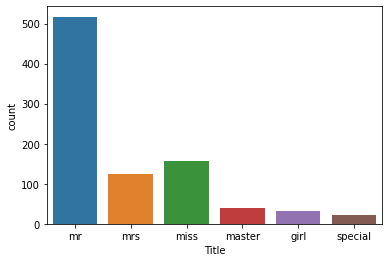

In [27]:
sns.countplot(x="Title", data=train);

In [28]:
# Create New Feature called child contains girl and master
train["child"] = Get_Child(train)
test["child"] = Get_Child(test)

In [29]:
train["child"].value_counts()

0    819
1     72
Name: child, dtype: int64

### Fill nan values in Age 
#### One solution is using scrapper from Encyclopedia Titanica website 
https://www.encyclopedia-titanica.org

Survivor_url = "https://www.encyclopedia-titanica.org/titanic-survivors-list/" <br>
dead_url = "https://www.encyclopedia-titanica.org/titanic-victims-list/"<br>

#Survivor with nan Age --> Survivor_nan_age<br>
Survivor_nan_age = passenger_nan_age[passenger_nan_age.Survived == 1]<br>

#Dead with nan Age --> Survivor_nan_age<br>
dead_nan_age = passenger_nan_age[passenger_nan_age.Survived == 0]<br>

The problem is Names in this dataset are not complete, So rarely will match with the right name <br>
and most of the time will git 404 page <br>
#### Second solution is to fill it with the median age values of same Title <br>

In [30]:
# Fill null ages with the median of each category in Tilte
train['Age'] = Fill_null_age(train)
test['Age'] = Fill_null_age(test)

In [31]:
# Check if Age changed 
train.Age.isna().sum()

0

##  Explore Ticket column

In [32]:
# Find if there's nan in Ticket column
train.Ticket.isna().sum()

0

Note:<br>
From previous, I have noticed that families share the same ticket value <br>
So, create a new feature called "HaveGroup" contains if this passenger was in group/ family/ child with a nany...etc <br>
Cause it's possible that people who know each either, rescued and help themself!  <br>

In [33]:
# Count each one with same Ticket
train_Groups = train.groupby("Ticket")["PassengerId"].count()
test_Groups = test.groupby("Ticket")["PassengerId"].count()

In [34]:
# Merge "Groups" panda series with train datafram on ticket values
train = train.merge(train_Groups, on="Ticket", how="left")

test = test.merge(test_Groups, on="Ticket", how="left")

In [35]:
# Change columns name PassengerId_x ---> PassengerId
#                     PassengerId_y ---> Group
train.rename(columns={'PassengerId_x': 'PassengerId', 'PassengerId_y': 'Group', "child": "Child"}, inplace=True)
test.rename(columns={'PassengerId_x': 'PassengerId', 'PassengerId_y': 'Group', "child": "Child"}, inplace=True)

In [36]:
# Create new feature HaveGroup True if Group > 1, False if not
train["HaveGroup"] = train["Group"] > 1
test["HaveGroup"] = test["Group"] > 1

In [37]:
train["Group"].unique()

array([1, 2, 4, 3, 7, 5, 6])

1 means this passenger according to these data wasn't share same ticket, so we need to adjust this column by minis it from 1 

In [38]:
# Correct group values 
train["Group"] = train["Group"] - 1
test["Group"] = test["Group"] - 1

In [39]:
# check that it groupped correcticly
print(train.shape)
train.sort_values(["Ticket"]).head()

(891, 17)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Child,Group,HaveGroup
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.50,B79,S,Maioni,miss,0,2,True
257,258,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.50,B77,S,Cherry,miss,0,2,True
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.50,B77,S,Rothes,miss,0,2,True
262,263,0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.65,E67,S,Taussig,mr,0,2,True
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.65,E67,S,Taussig,mrs,0,2,True


##  Explore Cabin column

Note: Might passengers who were in the lower Cabins couldn't survive and the others in the higher Cabins could <br>
ex. Cabin = C27<br>
Seprate each cabin to class and number <br>
cabin_class: C<br>
cabin_num: 27<br>

In [40]:
train["Cabin"].unique() 

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Most of cabins have char and one or two digit <br>
Figure out if there's less than this 


In [41]:
[c for c in train["Cabin"].unique()[1:] if (len(c) < 2)]

['D', 'T']

In [42]:
train[train.Cabin == "T"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Child,Group,HaveGroup
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,Blackwell,mr,0,0,False


In [43]:
train[train.Cabin == "D"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Child,Group,HaveGroup
292,293,0,2,"Levy, Mr. Rene Jacques",male,36.0,0,0,SC/Paris 2163,12.8750,D,C,Levy,mr,0,0,False
327,328,1,2,"Ball, Mrs. (Ada E Hall)",female,36.0,0,0,28551,13.0000,D,S,Ball,mrs,0,0,False
473,474,1,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23.0,0,0,SC/AH Basle 541,13.7917,D,C,Jerwan,mrs,0,0,False


In [44]:
[c for c in train["Cabin"].unique()[1:] if (len(c) > 4)]

['C23 C25 C27',
 'F G73',
 'D10 D12',
 'B58 B60',
 'F E69',
 'C22 C26',
 'B57 B59 B63 B66',
 'B96 B98',
 'B51 B53 B55',
 'F G63',
 'C62 C64',
 'B82 B84']

We have problem with Cabin number cause some Cabin values have more than one cabin<br>
Cabin Class gives information about in which surface the room was <br>
Cabin Number gives us information where the room was [right, middle, left] of the ship<br>

Note:<br>
The F Deck contain This areas --> R, J, H, G, E, C <br>
So, ['F G73', 'F E69', 'F G63'], are a special case, so let's separated it 

In [45]:
#  take just the first cabin for them all combined_cabin
Correct_Cabin(train)
Correct_Cabin(test)

In [46]:
# Cabin Classes 
train["CabinClass"] = Get_CabinClass(train)
test["CabinClass"] = Get_CabinClass(test)

full unknown cabin with 0

In [47]:
train["CabinClass"].fillna(0, inplace=True)
test["CabinClass"].fillna(0, inplace=True)

In [48]:
print(train["CabinClass"].isna().sum())
print(test["CabinClass"].isna().sum())

0
0


In [49]:
train.loc[((train.Pclass == 3) & (train.CabinClass.notnull())), "CabinClass"]

0      0.0
2      0.0
4      0.0
5      0.0
7      0.0
      ... 
882    0.0
884    0.0
885    0.0
888    0.0
890    0.0
Name: CabinClass, Length: 491, dtype: float64

#### Dealing with combined cabin
Most of the combined cabins belong to families <br>
so, I will take just the first cabin for them all cause they all cabins closed to each other <br>
ex. C23 C25 C27 <br>
23, 25, 27 are beside each other<br>

Notes from "https://www.encyclopedia-titanica.org/titanic-deckplans/location-t.html" <br>
#### The position of the cabin
Cabin Number:<br>
odd --> right<br>
even---> left<br>

front ----> <45<br>
middle ---> 46-90<br>
back -----> >90<br>
<br>
Ship Decks From top to bottom<br>
T, A, B, C, D, E, F, G<br>

In [50]:
for i in range(1,4):
    print("Number of null cabinaless in pclass {0} is {1}".format(i, ((train.Pclass == i) & train.CabinClass.isna()).sum()))

Number of null cabinaless in pclass 1 is 0
Number of null cabinaless in pclass 2 is 0
Number of null cabinaless in pclass 3 is 0


It make sense if most of pclass 1 passengers didn't have cabina  <br>
But those from pclass 1, and pclass 2 will fill there nan values with cabines that have same fare 

Assign to nan --> Random room numbers and random cabin for Pclass 1, 2

In [51]:
for i in range(1,4):
    print(train.loc[(train.Pclass == i),"CabinClass"].value_counts())

5.0    59
6.0    47
0.0    41
4.0    29
3.0    25
7.0    15
Name: CabinClass, dtype: int64
0.0    168
2.0      8
4.0      4
3.0      4
Name: CabinClass, dtype: int64
0.0    479
1.0      7
3.0      4
2.0      1
Name: CabinClass, dtype: int64


In [52]:
# Add new feature, the number of cabin
train["CabinNum"] = Get_CabinNumber(train)
test["CabinNum"] = Get_CabinNumber(test)

In [53]:
# Fill null values in fare 
train['Fare'] = train.Fare.fillna(train.Fare.median())
test['Fare'] = train.Fare.fillna(train.Fare.median())

In [54]:
# Add new Feature HaveCabin true if yes , false if not 
train["HaveCabin"] = Get_HaveCabin(train)
test["HaveCabin"] = Get_HaveCabin(test)

Identify Where the cabin was using previous info: <br>
#### The position of the cabin
Cabin Number:<br>
odd --> right<br>
even---> left<br>

front ----> <45<br>
middle ---> 46-90<br>
back -----> >90<br>
<br>
Ship Decks From top to bottom<br>
T, A, B, C, D, E, F, G<br>

### Add 2 new features position_x, position_y 
#### position_x --> right, left
#### position_y --> front, middle, back

In [55]:
# Add 2 new features position_x, position_y 
train["position_x"] = train["CabinNum"].apply(cal_position_x)
train["position_y"] = train["CabinNum"].apply(cal_position_y)

test["position_x"] = test["CabinNum"].apply(cal_position_x)
test["position_y"] = test["CabinNum"].apply(cal_position_y)

In [56]:
# split Fare, Age to 4 categories 
# Train
train['CatAge'] = pd.qcut(train.Age, q=4, labels=False )
train['CatFare']= pd.qcut(train.Fare, q=4, labels=False)

#Test
test['CatAge'] = pd.qcut(test.Age, q=4, labels=False )
test['CatFare']= pd.qcut(test.Fare, q=4, labels=False)

In [57]:
# Adding family size 
# Train
train['Fam_Size'] = train.Parch + train.SibSp

#Test
test['Fam_Size'] = test.Parch + test.SibSp

In [58]:
# Check if there's null values in Embarked
train[train["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Group,HaveGroup,CabinClass,CabinNum,HaveCabin,position_x,position_y,CatAge,CatFare,Fam_Size
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,...,1,True,6.0,28.0,True,1,3,3,3,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,...,1,True,6.0,28.0,True,1,3,3,3,0


Fill nan values with Embarked of people from class 1 

In [59]:
train[train["Pclass"] ==1 ]["Embarked"].value_counts()

S    127
C     85
Q      2
Name: Embarked, dtype: int64

Most of first class people ride the ship from S, so will fill nan values with S

In [60]:
train.loc[train["Embarked"].isnull(), "Embarked"] = "S"

Check which feature have trend i

In [61]:
cat_features = ["Pclass", "Sex", "Embarked", "Title", "Child", "Group", "HaveGroup", "CabinClass", "HaveCabin", "position_x", "position_y", "CatAge", "CatFare", "Fam_Size"]

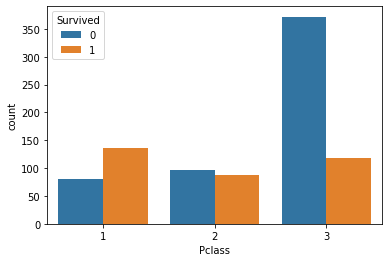

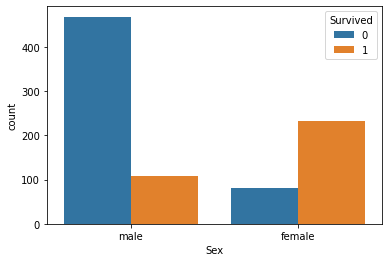

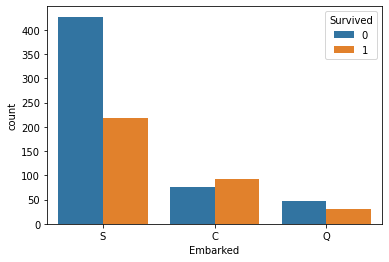

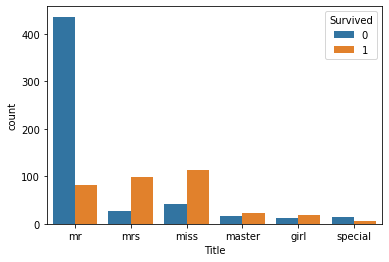

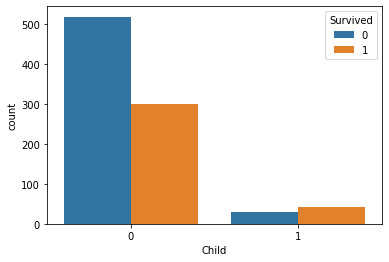

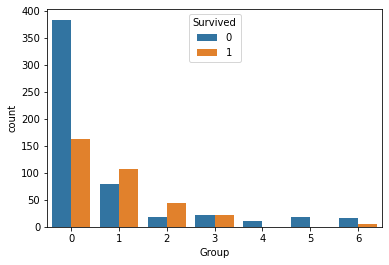

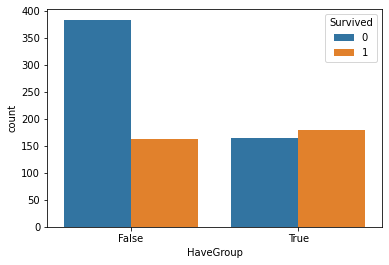

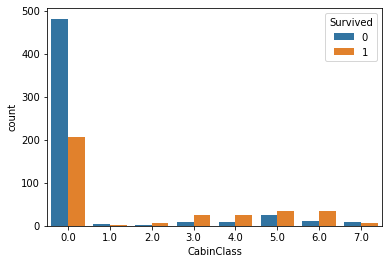

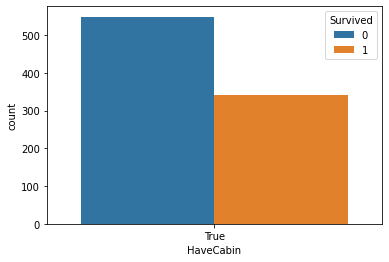

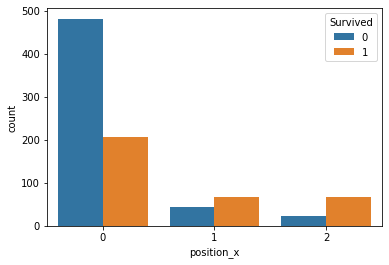

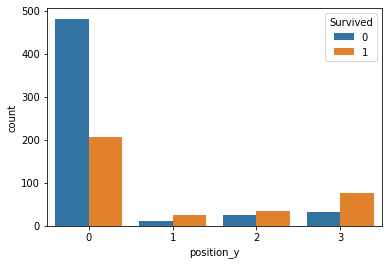

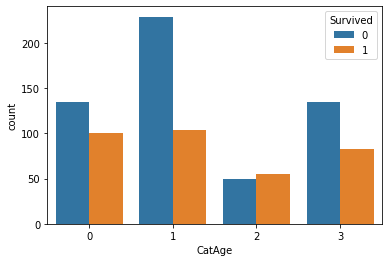

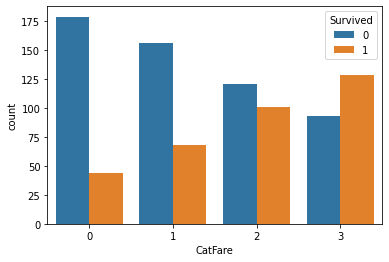

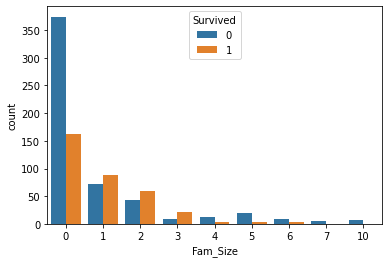

In [62]:
for feature in cat_features:
    g = sns.countplot(x=feature, hue="Survived", data=train)
    plt.show()
    

In [63]:
#Feature that may not have heavy impact
#["Child", "Group"]

In [64]:
featurs = ["Pclass", "Sex", "Embarked", "Title", "HaveGroup", "CabinClass", "HaveCabin", "position_x", "position_y", "CatAge", "CatFare", "Fam_Size"]

Text(0, 0.5, 'Count')

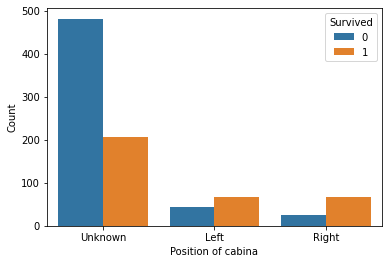

In [65]:
g = sns.countplot(x="position_x", hue="Survived", data=train)
g.set_xticklabels(["Unknown", "Left","Right"])
g.set_xlabel("Position of cabina")
g.set_ylabel("Count")

Text(0, 0.5, 'Count')

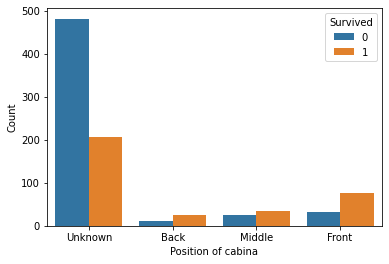

In [66]:
g = sns.countplot(x="position_y", hue="Survived", data=train)
g.set_xticklabels(["Unknown", "Back","Middle", "Front"])
g.set_xlabel("Position of cabina")
g.set_ylabel("Count")

In [67]:
train_x = train.drop(["PassengerId", "Survived"], axis=1)

Text(0, 0.5, 'Count')

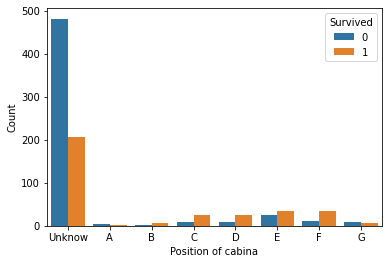

In [68]:
g = sns.countplot(x="CabinClass", hue="Survived", data=train)
g.set_xticklabels(["Unknow", "A","B", "C", "D", "E", "F", "G"])
g.set_xlabel("Position of cabina")
g.set_ylabel("Count")

position_x  position_y  Survived
 Unknown     Unknown     1           206
#Unknown     Unknown     0           481

 Left        Back        1            11
#Left        Back        0             7

 Left        Middle      1            16
#Left        Middle      0            13

 Left        Front       1            41
#Left        Front       0            24 

 Right       Back        1            14
#Right       Back        0             4

 Right       Middle      1            19
#Right       Middle      0            12 

 Right       Front       1            35
#Right       Front       0             8




In [69]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Surname', 'Title', 'Child',
       'Group', 'HaveGroup', 'CabinClass', 'CabinNum', 'HaveCabin',
       'position_x', 'position_y', 'CatAge', 'CatFare', 'Fam_Size'],
      dtype='object')

In [70]:
X = train_x[featurs]
y = train["Survived"]
X_test = test[featurs]

### Encoding Categorical Values 

In [71]:
# Ordinal_Categorical_Feature
#ord_feature = ["Pclass", "Title", "position_x", "position_y", "CabinClass", "Child"]

# Nominal_Categorical_Feature
#nom_feature= ['Sex', "Group", "HaveGroup", "HaveCabin"]

# All Catefgoriacl Features
#cat_feature = ["Pclass", "Title", "position_x", "position_y", "", "Child", 'Sex', 'Embarked', "Group", "HaveGroup", "HaveCabin"]

In [72]:
# labeled_Categories
label_cat = ["Title", "Sex", "Embarked"]

In [73]:
# labeled_Encoding 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for f in label_cat:
    X[f] = le.fit_transform(X[f])
    X_test[f] = le.fit_transform(X_test[f]) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [74]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
models = []
models.append(("Logistic Regression:",LogisticRegression(max_iter=1000)))

models.append(("Naive Bayes:",GaussianNB()))

models.append(("K-Nearest Neighbour:",KNeighborsClassifier(n_neighbors=3)))

models.append(("Support Vector Machine-linear:",SVC(kernel="linear", C=2)))
models.append(("Support Vector Machine-poly:",SVC(kernel="poly", degree=3, C=1.5)))
models.append(("Support Vector Machine-rbf:",SVC(kernel="rbf", C=2)))

models.append(("Decision Tree:",DecisionTreeClassifier()))
models.append(("Random Forest:",RandomForestClassifier(n_estimators=50)))

In [75]:
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    result = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    names.append(name)
    results.append(result)
    

"""model.fit(X_train, y_train)
coss_val(model,X_train, y_train, cv=5)
estimate_model(model, X_train, y_train, X_val, y_val)
feature_importance(model)"""
  
for i in range(len(names)):
    print(names[i],results[i].mean()*100)

Logistic Regression: 78.561797752809
Naive Bayes: 74.06991260923846
K-Nearest Neighbour: 79.68789013732834
Support Vector Machine-linear: 78.67290886392009
Support Vector Machine-poly: 82.26591760299625
Support Vector Machine-rbf: 82.26466916354556
Decision Tree: 80.24843945068663
Random Forest: 81.14481897627964


Will choose the model with the heighest accuracy --> Support Vector Machine-poly


In [76]:
test["Survived"] = SVC(kernel="poly", degree=3, C=1.5).fit(X, y).predict(X_test)
submission = test[["PassengerId", "Survived"]]
submission.to_csv('/kaggle/working/submission.csv', index=False)

In [77]:
from sklearn.metrics import f1_score

real_y = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
score = f1_score(real_y.Survived, test["Survived"], average='macro')
print("Thr f1 score of ",score)

Thr f1 score of  0.9437512233313761
